Comments: \
Visibility의 Density shape을 보면 끝에 집중되어있음

In [1]:
import numpy as np
import pandas as pd
from numpy.random import randn

import matplotlib.pyplot as plt
import seaborn as sns
import dataprep as dp
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, RANSACRegressor, Ridge, Lasso, ElasticNet

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import data
train = pd.read_csv('./data/train.csv')
train.drop(['id'], axis=1, inplace=True)
column_names = list(train.columns.values.tolist())

# Filling Missing Values

In [3]:
train.isna().sum()

hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Text(0.5, 1.0, 'Total Missing Value (%)')

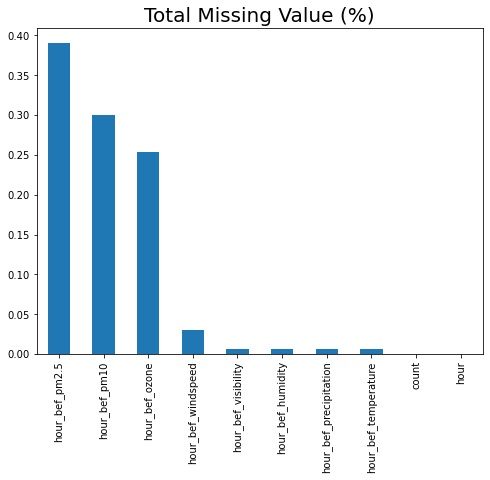

In [4]:
#2조분들 하신거 가져옴 ㅎㅎ!

total = train.isna().sum().sort_values(ascending=False)
percent = (train.isna().sum()/train.isna().sum().sum()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

hour_bef_pm2.5, pm10 같은 경우 결측치가 각각 대략 40%, 35% 달하기 때문에 굳이? 안 넣어도 될 것 같음
저번 학기 조별 과제 하신거 보니 결측치 40%인 특성들 제거해주심

In [5]:
train[train['hour_bef_temperature'].isna()]

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [6]:
train.drop(index=[934, 1035], inplace=True)

In [7]:
train.isna().sum()

hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          7
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone             74
hour_bef_pm10              88
hour_bef_pm2.5            115
count                       0
dtype: int64

Ozone은 결측치가 74개라서 Impute해줘야 할 것 같지만 Windspeed은 7개 밖에 되지 않기 때문에 해당 Record를 지워도 되긴함

In [8]:
imputation_compare = pd.DataFrame()
miss_idx = train.index[train['hour_bef_windspeed'].isna()]

### Original Method (시간별 평균)

In [80]:
ori_train = train.copy()

fill_dict = {}
idxs = ori_train[ori_train['hour_bef_windspeed'].isna()].index
att_by_hr = ori_train.groupby('hour').mean()['hour_bef_windspeed']
for idx in idxs:
    hr_mean = att_by_hr[ori_train['hour'][idx]]
    fill_dict[idx] = hr_mean
ori_train['hour_bef_windspeed'].fillna(fill_dict, inplace=True)

fill_dict = {}
idxs = ori_train[ori_train['hour_bef_ozone'].isna()].index
att_by_hr = ori_train.groupby('hour').mean()['hour_bef_ozone']
for idx in idxs:
    hr_mean = att_by_hr[ori_train['hour'][idx]]
    fill_dict[idx] = hr_mean
    if ori_train['hour'][idx] == 1:
        fill_dict[idx] = (0.033763 + 0.030492) / 2
ori_train['hour_bef_ozone'].fillna(fill_dict, inplace=True)

imputation_compare['Original'] = ori_train.loc[miss_idx, 'hour_bef_windspeed']
ori_train.isna().sum()

hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         0
hour_bef_ozone              0
hour_bef_pm10              88
hour_bef_pm2.5            115
count                       0
dtype: int64

### KNN Imputer

In [75]:
from sklearn.impute import KNNImputer

knn_train = train.copy()

imputer = KNNImputer(n_neighbors=20)
knn_train = imputer.fit_transform(knn_train)

knnImp = pd.DataFrame(knn_train)
knnImp.columns = column_names

imputation_compare['KNN Imputer'] = knnImp.loc[miss_idx, 'hour_bef_windspeed']
knnImp.isna().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [76]:
knnImp.loc[miss_idx, 'hour_bef_windspeed']

18      2.610
244     1.420
260     1.450
376     2.205
780     3.835
1138    3.700
1229    1.800
Name: hour_bef_windspeed, dtype: float64

### MICE Imputer

<br>
https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
<br>
Mice Explained: https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained

In [12]:
pip install impyute

Note: you may need to restart the kernel to use updated packages.


In [77]:
from impyute import mice

mice_train = train.to_numpy()
mice_train = mice(mice_train)

miceImp = pd.DataFrame(mice_train)
miceImp.columns = column_names

imputation_compare['MICE Imputer'] = miceImp.loc[miss_idx, 'hour_bef_windspeed']
miceImp.isna().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

### Iterative Imputer
<br> Bayesian Ridge 사용

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

it_train = train.copy()

it_train = IterativeImputer(random_state=2021).fit_transform(it_train)

itImp = pd.DataFrame(it_train)
itImp.columns = column_names

imputation_compare['Iterative Imputer'] = itImp.loc[miss_idx, 'hour_bef_windspeed']
itImp.isna().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [10]:
imputation_compare #'hour_bef_windspeed' 값임
#상당히 유사하다.
#그냥 다 가져가서 /4 하는 것은 어떨까

,Iterative Imputer
18,2.875890
244,1.682353
260,2.242214
376,2.141721
780,3.846585
1138,3.700000
1229,1.800000


# Outliers

### Isolation Forest

In [82]:
# 참고: https://donghwa-kim.github.io/iforest.html
# Regression Tree 기반의 Split으로 모든 데이터 관측치를 고립시키는 방법(?)
# 비정상 데이터가 고립되려면, root node와 가까운 depth를 가짐
# 정상 데이터가 고립되려면, tree의 말단노드에 가까운 depth를 가짐
# 특정 한 개체가 isolation 되는 leaf 노드(terminal node)까지의 거리를 outlier score로 정의하며,
# 그 평균거리(depth)가 짧을 수록 outlier score는 높아짐

from sklearn.ensemble import IsolationForest
iso = IsolationForest(n_jobs=-1)

#Visilbility의 density shape 때문에 제외시킴
itImp_IF_mid = itImp.drop(['hour_bef_precipitation', 'hour_bef_visibility', 'count'], axis=1)

yhat = iso.fit_predict(itImp_IF_mid)
mask = yhat != -1
itImp_IF = itImp[mask]

itImp_IF[['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']].info()
#알고리즘이 Stochastic한 것 같다: 수가 계속 변함

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 1456
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hour                  1225 non-null   float64
 1   hour_bef_temperature  1225 non-null   float64
 2   hour_bef_windspeed    1225 non-null   float64
 3   hour_bef_humidity     1225 non-null   float64
 4   hour_bef_visibility   1225 non-null   float64
 5   hour_bef_ozone        1225 non-null   float64
dtypes: float64(6)
memory usage: 67.0 KB


### Minimum Covariance Determinant

In [83]:
# 참고: https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html
# 만약 사용하고자 하는 변수가 가우시안 분포를 가지고 있다면, 이 특성을 이용해 Elliptic하게 묶에서 외곽의 데이터는
# 버리는 방법으로 Outlier 제거가 가능하다(는 알고리즘)

from sklearn.covariance import EllipticEnvelope
ee = EllipticEnvelope(contamination=0.1)

#가우시안 분포 아닌 변수들 제거
itImp_MCD_mid = itImp.drop(['hour', 'hour_bef_precipitation', 'hour_bef_visibility', 'count'], axis=1)

yhat = ee.fit_predict(itImp_MCD_mid)
mask = yhat != -1
itImp_MCD = itImp[mask]

itImp_MCD[['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']].info()
# 얘는 일정함

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1311 entries, 0 to 1456
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hour                  1311 non-null   float64
 1   hour_bef_temperature  1311 non-null   float64
 2   hour_bef_windspeed    1311 non-null   float64
 3   hour_bef_humidity     1311 non-null   float64
 4   hour_bef_visibility   1311 non-null   float64
 5   hour_bef_ozone        1311 non-null   float64
dtypes: float64(6)
memory usage: 71.7 KB


### Original Method (IQR)

In [11]:
col_name=['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']

itImp_mid = itImp.copy()

for ilt in col_name:
    Q1=itImp_mid[ilt].quantile(0.25)
    Q3=itImp_mid[ilt].quantile(0.75)
    IQR=Q3-Q1
    train_delout=itImp_mid[(itImp_mid[ilt]<(Q1 - 1.5*IQR)) | (itImp_mid[ilt]>(Q3+1.5*IQR))]
    itImp_mid=itImp_mid.drop(train_delout.index, axis=0)
itImp_mid[col_name].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1433 entries, 0 to 1456
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hour                  1433 non-null   float64
 1   hour_bef_temperature  1433 non-null   float64
 2   hour_bef_windspeed    1433 non-null   float64
 3   hour_bef_humidity     1433 non-null   float64
 4   hour_bef_visibility   1433 non-null   float64
 5   hour_bef_ozone        1433 non-null   float64
dtypes: float64(6)
memory usage: 78.4 KB


# Modeling

In [12]:
col = ['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_ozone']

'''X = itImp_IF[col]
y = itImp_IF[['count']]
X_train_IF, X_val_IF, y_train_IF, y_val_IF = train_test_split(X, y, test_size=0.33, random_state=2021)

X = itImp_MCD[col]
y = itImp_MCD[['count']]
X_train_MCD, X_val_MCD, y_train_MCD, y_val_MCD = train_test_split(X, y, test_size=0.33, random_state=2021)'''

X = itImp_mid[col]
y = itImp_mid[['count']]
X_train_ori, X_val_ori, y_train_ori, y_val_ori = train_test_split(X, y, test_size=0.33, random_state=2021)

### Isolation Forest

In [86]:
#Random Forest 사용 https://hleecaster.com/ml-random-forest-concept/
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

IF_RF = RandomForestRegressor(max_depth=10, random_state=2021)
IF_RF.fit(X_train_IF, y_train_IF)
y_preds = IF_RF.predict(X_val_IF)

# why use rmse? : https://data101.oopy.io/mae-vs-rmse
rmse_IF = np.sqrt(mean_squared_error(y_val_IF, y_preds))
print(rmse_IF)

40.336527966694064


### MCD

In [87]:
MCD_RF = RandomForestRegressor(max_depth=10, random_state=2021)
MCD_RF.fit(X_train_MCD, y_train_MCD)
y_preds = MCD_RF.predict(X_val_MCD)

rmse_MCD = np.sqrt(mean_squared_error(y_val_MCD, y_preds))
print(rmse_MCD)

40.65703831202569


### IQR

In [15]:
from sklearn.ensemble import RandomForestRegressor

ori_RF = RandomForestRegressor(max_depth=10, random_state=2021)
ori_RF.fit(X_train_ori, y_train_ori)
y_preds = ori_RF.predict(X_val_ori)

rmse_ori = np.sqrt(mean_squared_error(y_val_ori, y_preds))
print(rmse_ori)

37.64945833929329


In [17]:
from sklearn.ensemble import ExtraTreesRegressor

best_reg = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=2021)
best_reg.fit(X_train_ori, y_train_ori)
y_preds = best_reg.predict(X_val_ori)

rmse = np.sqrt(mean_squared_error(y_val_ori, y_preds))
print(rmse)

37.47143608933198


결론: IQR 방식이 제일 정확함 X
max_depth 늘리니까 MCD IF 방식의 rmse가 엄청 줄음

### Scaling까지 적용하면 어떨까

In [93]:
scaler = StandardScaler()
itImp_scaling = itImp_mid[['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_ozone', 'count']].copy()

after_scaling = pd.DataFrame(scaler.fit_transform(itImp_scaling[['hour_bef_temperature', 'hour_bef_windspeed', 
                                                'hour_bef_humidity', 'hour_bef_ozone']]))

for i, att in enumerate(['hour_bef_temperature', 'hour_bef_windspeed','hour_bef_humidity', 'hour_bef_ozone']):
    itImp_scaling[att] = after_scaling.loc[:, i]
itImp_scaling = itImp_scaling.loc[:1432, :]

X = itImp_scaling[col]
y = itImp_scaling[['count']]
X_train_scaling, X_val_scaling, y_train_scaling, y_val_scaling = train_test_split(X, y, test_size=0.33, random_state=2021)

In [94]:
scaling_rf = RandomForestRegressor(max_depth=3, random_state=2021)
scaling_rf.fit(X_train_scaling, y_train_scaling)
y_preds = scaling_rf.predict(X_val_scaling)

rmse_scaling = np.sqrt(mean_squared_error(y_val_scaling, y_preds))
print(rmse_scaling)

47.97507111491688


### 그냥 모든 attribute 사용한다면?

In [95]:
itImp_mid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1433 entries, 0 to 1456
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hour                    1433 non-null   float64
 1   hour_bef_temperature    1433 non-null   float64
 2   hour_bef_precipitation  1433 non-null   float64
 3   hour_bef_windspeed      1433 non-null   float64
 4   hour_bef_humidity       1433 non-null   float64
 5   hour_bef_visibility     1433 non-null   float64
 6   hour_bef_ozone          1433 non-null   float64
 7   hour_bef_pm10           1433 non-null   float64
 8   hour_bef_pm2.5          1433 non-null   float64
 9   count                   1433 non-null   float64
dtypes: float64(10)
memory usage: 163.1 KB


In [96]:
X = itImp_IF[itImp_mid.columns.difference(['count'])]
y = itImp_IF[['count']]
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(X, y, test_size=0.33, random_state=2021)

allatri_rf = RandomForestRegressor(max_depth=10, random_state=2021)
allatri_rf.fit(X_train_all, y_train_all)
y_preds = allatri_rf.predict(X_val_all)

rmse_allatri = np.sqrt(mean_squared_error(y_val_all, y_preds))
print(rmse_allatri)

39.80085369794372


### Different Regs (Voting, ET)

In [27]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [97]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor, plot_importance, plot_tree
import graphviz

dt_reg = DecisionTreeRegressor(criterion='mse', max_depth=10, random_state=2021)
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=2021)
et_reg = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=2021)
ada_reg = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=2021)
bag_reg = BaggingRegressor(n_estimators=20, random_state=2021)
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=2021)

regressors = [dt_reg, rf_reg, et_reg, ada_reg, bag_reg, gb_reg]

In [98]:
for reg in regressors:
    print("Training the", reg)
    reg.fit(X_train_IF, y_train_IF)

Training the DecisionTreeRegressor(max_depth=10, random_state=2021)
Training the RandomForestRegressor(max_depth=10, random_state=2021)
Training the ExtraTreesRegressor(max_depth=10, random_state=2021)
Training the AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=2021)
Training the BaggingRegressor(n_estimators=20, random_state=2021)
Training the GradientBoostingRegressor(random_state=2021)


In [99]:
[reg.score(X_val_IF, y_val_IF) for reg in regressors]
#DT, ada 제외하겠음

[0.6182593082107082,
 0.7642106854883921,
 0.7572459275402712,
 0.7119963028903662,
 0.759473431512028,
 0.7397370705023624]

In [100]:
named_estimators = [
    ("rf", rf_reg),
    ("et", et_reg),
    ("bag", bag_reg),
    ("gb", gb_reg),
]
voting_reg = VotingRegressor(named_estimators)
voting_reg.fit(X_train_IF, y_train_IF)
voting_reg.score(X_val_IF, y_val_IF)

0.7642168393606792

In [101]:
pred = voting_reg.predict(X_val_IF)

rmse = np.sqrt(mean_squared_error(y_val_IF, pred))
print(rmse)

40.3360015911419


In [102]:
pred = voting_reg.estimators_[1].predict(X_val_IF)
rmse = np.sqrt(mean_squared_error(y_val_IF, pred))
print(rmse)
#그냥 et가 성능짱인듯...?

40.92792388558699


In [103]:
'''from sklearn.tree import export_graphviz

dot_data = export_graphviz(voting_clf.estimators_[1].estimators_[0])
graph = graphviz.Source(dot_data)
graph'''

'from sklearn.tree import export_graphviz\n\ndot_data = export_graphviz(voting_clf.estimators_[1].estimators_[0])\ngraph = graphviz.Source(dot_data)\ngraph'

In [104]:
et_reg_ori = ExtraTreesRegressor(n_estimators=1000, max_depth=10, random_state=2021)
et_reg_ori.fit(X_train_IF, y_train_IF)
pred = voting_reg.estimators_[1].predict(X_val_IF)
rmse = np.sqrt(mean_squared_error(y_val_IF, pred))
print(rmse)

40.92792388558699


### XGBoost

In [105]:
xgbr = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021)
xgbr.fit(X_train_IF, y_train_IF)
pred = xgbr.predict(X_val_IF)

rmse = np.sqrt(mean_squared_error(y_val_IF, pred))
print(rmse)

42.133570222911764


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

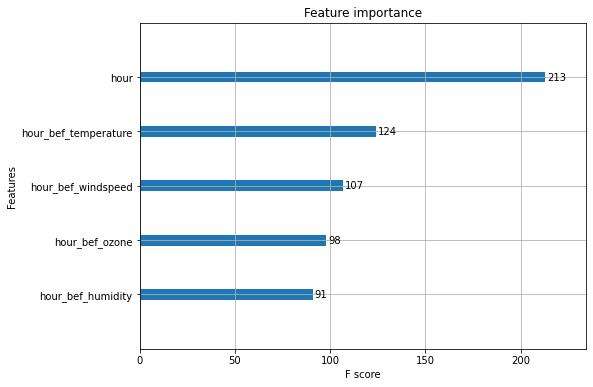

In [106]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgbr, ax=ax)

40.925139293241514


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

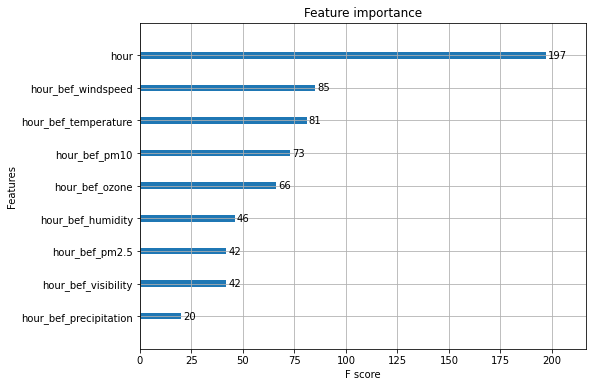

In [107]:
xgbr_all = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021)
xgbr_all.fit(X_train_all, y_train_all)
pred = xgbr_all.predict(X_val_all)

rmse = np.sqrt(mean_squared_error(y_val_all, pred))
print(rmse)

fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgbr_all, ax=ax)

### 상위 6개만 가지고...

41.55150635268687


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

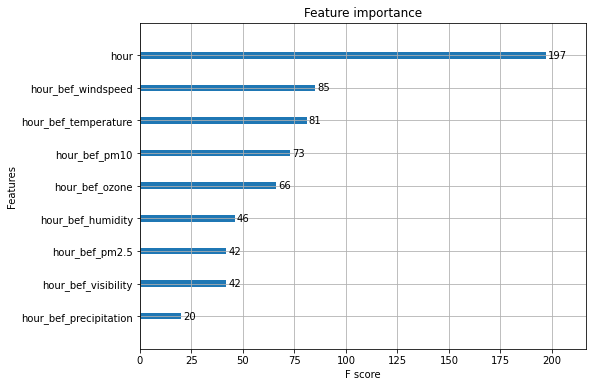

In [108]:
X = itImp_IF[itImp_mid.columns.difference(['count', 'hour_bef_precipitation', 'hour_bef_pm2.5', 'hour_bef_humidity'])]
y = itImp_IF[['count']]
X_train_all6, X_val_all6, y_train_all6, y_val_all6 = train_test_split(X, y, test_size=0.33, random_state=2021)

xgbr_all_top6 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021)
xgbr_all_top6.fit(X_train_all6, y_train_all6)
pred = xgbr_all_top6.predict(X_val_all6)

rmse = np.sqrt(mean_squared_error(y_val_all6, pred))
print(rmse)

fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgbr_all, ax=ax)

In [109]:
X = itImp_IF[itImp_mid.columns.difference(['count'])]
y = itImp_IF[['count']]
X_train_IFa, X_val_IFa, y_train_IFa, y_val_IFa = train_test_split(X, y, test_size=0.33, random_state=2021)

fit_reg = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=2021)
fit_reg.fit(X_train_IFa, y_train_IFa)

print(fit_reg.feature_importances_)
# use hour, ozone, precipitation, 2.5, temperature, visibility
#0, 6, 2, 8, 1, 5

pred = best_reg.predict(X_val_IF6)
rmse = np.sqrt(mean_squared_error(y_val_IF6, pred))
print(rmse)

[0.56344448 0.04070019 0.03906542 0.02636396 0.02177752 0.04020444
 0.18981505 0.02978433 0.04884462]


NameError: name 'best_reg' is not defined

In [110]:
X = itImp_IF[itImp_mid.columns.difference(['count', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_pm10'])]
y = itImp_IF[['count']]
X_train_IF6, X_val_IF6, y_train_IF6, y_val_IF6 = train_test_split(X, y, test_size=0.33, random_state=2021)

best_reg = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=2021)
best_reg.fit(X_train_IF6, y_train_IF6)

pred = best_reg.predict(X_val_IF6)
rmse = np.sqrt(mean_squared_error(y_val_IF6, pred))
print(rmse)
#cross_val = cross_validate(
#    estimator=best_reg,
#    X=X_train_IF6, y=y_train_IF6,
#    cv=5
#)

38.99693456750403


In [111]:
itImp_IF.columns.values

array(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype=object)

In [112]:
from sklearn.ensemble import StackingRegressor

lr_final=LinearRegression()

estimators= [('knn_reg',KNeighborsRegressor(n_neighbors=10)),('rf_reg',RandomForestRegressor(max_depth=3, n_jobs=-1, n_estimators=300, random_state=2021)),
('aba_reg',AdaBoostRegressor(n_estimators=300,learning_rate=0.3,random_state=2021,loss='square')),
('dt_reg',DecisionTreeRegressor(max_depth=5,random_state=2021))]

reg= StackingRegressor(estimators=estimators, final_estimator=lr_final)
reg.fit(X_train, y_train)

NameError: name 'KNeighborsRegressor' is not defined